<a href="https://colab.research.google.com/github/EternalSorrrow/bak/blob/master/ra2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MURA Pre-train

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#@title Define input sizes and number of classes

input_size = (320, 320)
n_classes = 2

In [0]:
#@title Paths definition
data_folder='/content/drive/My Drive/Work/ML/RA2/mura_pretrain/data/'
checkpoints_foler='/content/drive/My Drive/Work/ML/RA2/mura_pretrain/model_checkpoints/'
saved_models_folder='/content/drive/My Drive/Work/ML/RA2/mura_pretrain/saved_models/'

In [0]:
#@title Function to load data from hdf5
import h5py
import numpy as np

def import_from_hdf5(path, verbose=False):
    with h5py.File(path, "r", driver='core') as hdf5_file:

        train_data = None
        batch_begin, batch_end = 0, 200
        train_samples = len(hdf5_file['train_img'])
        while True:
            batch_end = min(batch_end, train_samples)
            batch = hdf5_file['train_img'][batch_begin:batch_end, :, :, :]
            if train_data is None:
                train_data = batch
            else:
                train_data = np.concatenate([train_data, batch], axis=0)
            if verbose:
                print('Loaded', batch_end, 'samples of', train_samples, 'samples of train data')
            if batch_end == train_samples:
                break
            else:
                batch_begin = batch_end
                batch_end += 200

        train_labels = hdf5_file['train_labels'][:]

        valid_data = None
        batch_begin, batch_end = 0, 200
        val_samples = len(hdf5_file['val_img'])
        while True:
            batch_end = min(batch_end, val_samples)
            batch = hdf5_file['val_img'][batch_begin:batch_end, :, :, :]
            if valid_data is None:
                valid_data = batch
            else:
                valid_data = np.concatenate([valid_data, batch], axis=0)
            if verbose:
                print('Loaded', batch_end, 'samples of', val_samples, 'samples of val data')
            if batch_end == val_samples:
                break
            else:
                batch_begin = batch_end
                batch_end += 200

        valid_labels = hdf5_file['val_labels'][:]

        train_data, valid_data = train_data[:, :, :, :], valid_data[:, :, :, :]

    return train_data, train_labels, valid_data, valid_labels

In [24]:
#@title Load hand data
from keras.utils import to_categorical

hand_train, hand_train_labels, hand_valid, hand_valid_labels = import_from_hdf5(data_folder + 'hand.hdf5')

hand_train_labels = to_categorical(hand_train_labels, n_classes)
hand_valid_labels = to_categorical(hand_valid_labels, n_classes)

print(hand_train.shape, hand_train_labels.shape, hand_valid.shape, hand_valid_labels.shape)

KeyboardInterrupt: ignored

In [0]:
#@title Visualize some samples
import matplotlib.pyplot as plt

shift = 1520
n_cols, n_rows = 3, 2

fig, ax = plt.subplots(figsize=(4 * n_cols, 4 * n_rows), ncols=n_cols, nrows=n_rows)

for i in range(n_rows):
    for k in range(n_cols):
        label = 'Normal' if np.argmax(hand_train_labels[shift + i * n_cols + k]) == 0 else 'Abnormal'
        ax[i, k].imshow(hand_train[shift + i * n_cols + k].astype(np.uint8))
        ax[i, k].set_xlabel(label)

plt.show()

In [0]:
#@title Class weights computing
#Class weights computing to penalize errors on more rare class

from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight(
                'balanced',
                np.unique(np.argmax(hand_train_labels, axis=1)),
                np.argmax(hand_train_labels, axis=1)
              )

class_weight

In [0]:
#@title Model definition
#Model definition
import os
import tempfile
import keras
import tensorflow as tf
from keras import backend as K
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201, preprocess_input
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from keras.optimizers import adam, sgd
from keras import regularizers
from keras.models import model_from_json

#Force the batchnorm extract statistics directly from validation batch
#K.set_learning_phase(1)

#Hack to add a regularization to a pre-trained model
#https://sthalles.github.io/keras-regularizer/
def add_regularization(model, regularizer=None):

    if not isinstance(regularizer, regularizers.Regularizer):
        print("Regularizer must be a subclass of keras.regularizers.Regularizer")
        return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

    return model

def set_batchnorm_params(model, trainable=True, scale=True, center=True, momentum=0.99):
  for layer in model.layers:
    if 'bn' in layer.name:
      setattr(layer, 'trainable', trainable)
      setattr(layer, 'scale', scale)
      setattr(layer, 'center', center)
      setattr(layer, 'momentum', momentum)

  return model

def apply_changes_to_model(model):
    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)
    #tmp_weights_path = model_folder + 'tmp_weights.h5'
    #model.save_weights(tmp_weights_path, overwrite=True)

    # load the model from the config
    model = model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)

    return model

def get_compiled_model_instance(lr=0.0001, version=121, pooling='avg', weights='imagenet',
                                freeze=0, optimizer='adam', beta1=0.9, beta2=0.999,
                                regularizer=None, regularize_output=False, reg_lambda=0.01,
                                label_smoothing=0.0,
                                bn_trainable=True,
                                bn_scale=True,
                                bn_center=True,
                                bn_momentum=0.99,
                                ):

    def loss(y_true, y_pred): #Wrapping a tf loss to the keras interface with only 2 args
        return categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    
    def pure_loss(y_true, y_pred): #Will be passed as a metric to be watched as a "pure" (without regularization) loss
        return categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)

    def get_lr_metric(optimizer): #Custom metric to monitor learning rate
        def lr(y_true, y_pred):
            return optimizer.lr
        return lr

    def get_kappa_metric(num_classes):
      def kappa(y_true, y_pred):
        kappa, update_op = tf.contrib.metrics.cohen_kappa(
          K.argmax(y_true, axis=1), 
          K.argmax(y_pred, axis=1), 
          num_classes,
        )
        
        with tf.control_dependencies([update_op]):
            kappa = K.identity(kappa)
        return kappa
      
      return kappa
    
    if regularizer=='l1':
        regularizer=regularizers.l1(reg_lambda)
    elif regularizer=='l2':
        regularizer=regularizers.l2(reg_lambda)
    elif not regularizer:
        pass
    elif len(reg_lambda)==2:
        l1, l2 = reg_lambda
        regularizer=regularizers.l1_l2(l1=l1, l2=l2)
    else:
        raise ValueError('Unknown regularizer')
    
    base_model = None
    if version==121:
        base_model = DenseNet121(include_top=False, weights=weights, input_shape=None, pooling=pooling)
    elif version==169:
        base_model = DenseNet169(include_top=False, weights=weights, input_shape=None, pooling=pooling)
    elif version==201:
        base_model = DenseNet201(include_top=False, weights=weights, input_shape=None, pooling=pooling)
    else:
        raise ValueError('Unknown DenseNet version')


    for layer in base_model.layers: layer.trainable = False #Freeze all base layers

    if not freeze: #Unfreeze model if no freeze specified
      for layer in base_model.layers: layer.trainable = True
    else: #Unfreeze a part of model based on the freeze parameter
      for layer in base_model.layers[freeze:]: layer.trainable = True
    
    if regularizer:
        base_model=add_regularization(base_model, regularizer=regularizer)

    base_model=set_batchnorm_params(
        base_model, bn_trainable, bn_scale, bn_center, bn_momentum
    )
    base_model=apply_changes_to_model(base_model)    

    x = base_model.output
    predictions = Dense(n_classes, activation='softmax',
                        kernel_regularizer=regularizer if regularize_output else None
                        )(x)

    if optimizer=='adam':
        optimizer=adam(lr=lr, beta_1=beta1, beta_2=beta2)
    elif optimizer=='sgd':
        optimizer=sgd(lr=lr, momentum=beta1, nesterov=True)
    else:
        raise ValueError('Unknown optimizer')

    lr_metric = get_lr_metric(optimizer)
    kappa = get_kappa_metric(n_classes)

    metrics=['acc', lr_metric, pure_loss, kappa]

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [0]:
#@title Functions to load model from file
from keras.models import load_model

import re

def parse_filename(path):
    text = re.compile('[\w]+-(\d+)-([-+]?[0-9]*\.?[0-9]+)-([-+]?[0-9]*\.?[0-9]+).hdf5').findall(path)
    if len(text) == 0:
        return None
    text = text[0]
    return int(text[0]), float(text[1]), float(text[2])
  
def load_model_from_checkpoint(path, label_smoothing=0.0):
  
    def loss(y_true, y_pred): #Wrapping a tf loss to the keras interface with only 2 args
        return categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)

    def pure_loss(y_true, y_pred): #Will be passed as a metric to be watched as a "pure" (without regularization) loss
        return categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)

    def get_lr_metric(optimizer): #Custom metric to monitor learning rate
        def lr(y_true, y_pred):
            return optimizer.lr
        return lr

    def placeholder_lr(x, y): #We need placeholder since lr metric definition requires model's optimizer
        return tf.convert_to_tensor(1.0, np.float32)

    def get_kappa_metric(num_classes):
      def kappa(y_true, y_pred):
        kappa, update_op = tf.contrib.metrics.cohen_kappa(
          K.argmax(y_true, axis=1), 
          K.argmax(y_pred, axis=1), 
          num_classes,
        )
        
        with tf.control_dependencies([update_op]):
            kappa = K.identity(kappa)
        return kappa
      
      return kappa

    #Load the model with placeholder
    model = load_model(path, custom_objects={'loss' : loss,
                                             'lr' : placeholder_lr,
                                             'pure_loss' : pure_loss,
                                             'kappa' : get_kappa_metric(n_classes)})
    lr = get_lr_metric(model.optimizer) #Define the correct lr metric

    #Reload the model, now with the lr metric initialized
    model = load_model(path, custom_objects={'loss' : loss,
                                             'lr' : lr,
                                             'pure_loss' : pure_loss,
                                             'kappa' : get_kappa_metric(n_classes)})

    K.get_session().run(tf.global_variables_initializer())
    K.get_session().run(tf.global_variables_initializer())
    
    return model


In [0]:
#@title Modular live loss plotter

#Modular live loss plotter for Keras models
#Allows to create custom layouts of per-batch or per-epoch plots for different metrics

#Monitor class defines a plot, which either may be batch or epoch-scoped, and may contain several graphs
#Batch monitor plots its values per batch, and refreshes itself on new epoch begin
#Epoch monitor plots its values per epoch, and performs no refresh
#All values/last N values displaying
#Log-scale/Linear scale displaying

#Plotter callback handles different Monitors and responds to the actual plotting
#Defines a grid where Monitors will be drawn, grid size, refresh rate in batches
#when the Monitors will be re-drawn in addition to per-epoch update
#Plotter can be silenced to disable plotting and only archivate per-epoch data

from IPython.display import clear_output
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class Monitor():
    def __init__(self, scope='epoch', monitors= [ 'loss' ], plot_last=-1, log_scale=False, precision=4):
        self.scope = scope.lower()
        self.monitors = [ monitor.lower() for monitor in monitors ]
        self.plot_last = max(0, plot_last)
        self.x = []
        self.ys = [ [] for monitor in monitors ]
        self.log_scale = log_scale
        self.precision = precision

    def reinit(self):
        self.x = []
        self.ys = [ [] for monitor in self.monitors ]

    def update(self, iteration, logs={}):
        self.x.append(iteration)
        
        for i, monitor in enumerate(self.monitors):
            if logs.get(monitor) is not None:
                self.ys[i].append(logs.get(monitor))
            else:
                pass #Action to execute when cannot get info for a certain monitor

    def plot(self, axis):
        x_data = self.x[ -self.plot_last : ]
        y_array = [ y_data[ -self.plot_last : ] for y_data in self.ys ]

        for i, y_data in enumerate(y_array):
            label = self.monitors[i] + '_' + self.scope #Compose graph name
            if self.log_scale:
                axis.set_yscale('log') #Set up scale
                
            if len(x_data) == len(y_data): #If data are coherent, plot them
                axis.plot(x_data, y_data, label=label)

                if self.precision > 0 and len(y_data) > 0: #If there's a last point plotted, print its value
                    text = str(round(y_data[-1],  self.precision))
                    axis.text(x_data[-1], y_data[-1], text)
            else:
                continue
                
        label = {'batch' : 'Batches', 'epoch' : 'Epochs'} #Set up x-label
        axis.set_xlabel(label[self.scope])
        
        axis.legend()


class Plotter(Callback):
    def __init__(self, scale=5, n_cols=2, n_rows=1, monitors=[], refresh_rate=-1, silent=False):
        if (n_cols * n_rows < len(monitors)):
            raise ValueError('Grid is too small to fit all monitors!')

        self.n_cols = n_cols
        self.n_rows = n_rows
        self.scale = scale

        self.monitors = monitors

        self.batch_monitors, self.epoch_monitors = [], []

        for monitor in monitors:
            if monitor.scope == 'epoch':
                self.epoch_monitors.append(monitor)
            elif monitor.scope == 'batch':
                self.batch_monitors.append(monitor)

        self.refresh_rate = refresh_rate
        self.silent = False

    def on_train_begin(self, logs={}):
        pass

    def on_epoch_begin(self, epoch, logs={}):
        [ monitor.reinit() for monitor in self.batch_monitors ]

    def plot(self):
        clear_output(wait=True)

        figsize = ( self.scale * self.n_cols, self.scale * self.n_rows)
        fig, ax = plt.subplots(figsize=figsize, ncols=self.n_cols, nrows=self.n_rows)

        for index, axis in enumerate(ax.flat):
          if index < len(self.monitors):
              self.monitors[index].plot(axis)

        plt.show()

    def on_batch_end(self, batch, logs={}):
        [ monitor.update(batch, logs) for monitor in self.batch_monitors ]

        if self.silent or batch == 0 or self.refresh_rate <= 0 or batch % self.refresh_rate != 0:
            return

        self.plot()

    def on_epoch_end(self, epoch, logs={}):
        [ monitor.update(epoch, logs) for monitor in self.epoch_monitors ]

        if self.silent:
            return

        self.plot()

    def reinit(self):
      [ monitor.reinit() for monitor in self.monitors ]


In [0]:
#@title Restarting lr callback
#Restarting LR with different slopes

class RestartingLR(Callback):
    def __init__(self, min_lr=0.0001, max_lr=0.001, warmup_t=0, decrease_t=50, warmup='linear', decrease='cosine',
               warmup_enlengthen=1.0, decrease_enlengthen=1.0, cycles_demphing=1.0, epoch_shift=0,
               checkpoint_on_cycle_end=False, path=None, weights_only=False, verbose=True):
    
        super(RestartingLR, self).__init__()
        self.min_lr=min_lr
        self.max_lr=max_lr
        self.decrease_t=decrease_t
        self.warmup_t=warmup_t

        #LR value functions depending on the passed epoch number from last restart squashed to the [0, 1] interval
        #Functions correspond to decrease, to compute increase with them use 1 - x instead
        functions =  {
            'linear' : lambda x, min_lr, max_lr : (min_lr - max_lr) * x + max_lr,
            'cosine' : lambda x, min_lr, max_lr : (max_lr - min_lr) * (np.cos(x * np.pi) + 1) * 1/2 + min_lr,

            #Linear descend of lr's exponents. If min_lr=1e-7 and max_lr=1e-3,
            #lr will be 10^f(x), where f(x) is a linear function with values descending from -3 to -7 
            'log' : lambda x, min_lr, max_lr: np.exp(np.log(min_lr/max_lr) * x + np.log(max_lr))
            }

        if warmup not in functions.keys(): raise ValueError('No such warmup function available')
        if decrease not in functions.keys(): raise ValueError('No such decrease function available')

        self.warmup=functions[warmup]
        self.decrease=functions[decrease]

        self.warmup_enlengthen=warmup_enlengthen
        self.decrease_enlengthen=decrease_enlengthen
        self.cycles_demphing=cycles_demphing

        if epoch_shift < 0: raise ValueError('Epoch shift should be >= 0')

        self.epoch_shift=epoch_shift

        self.checkpoint=checkpoint_on_cycle_end
        if path is None and checkpoint_on_cycle_end: raise ValueError('Empty path while checkpointing is on')

        self.path=path
        self.verbose=verbose
        self.weights_only=weights_only

    def lr_value(self, epoch=0):
        epoch+=self.epoch_shift
        cycles_passed, decrease_t, warmup_t = 0, self.decrease_t, self.warmup_t

        cycle_epoch=epoch

        while True:
            if cycle_epoch - (decrease_t + warmup_t) >= 0:
                cycle_epoch -= decrease_t + warmup_t
                decrease_t *= self.decrease_enlengthen
                warmup_t *= self.warmup_enlengthen
                decrease_t, warmup_t = int(decrease_t), int(warmup_t)
                cycles_passed += 1
            else:
                break

        lr, min_lr, max_lr = None, self.min_lr, self.min_lr + (self.max_lr - self.min_lr) * (self.cycles_demphing ** cycles_passed)

        if cycle_epoch < warmup_t:
            arg = 1 - cycle_epoch / warmup_t
            lr = self.warmup(arg, min_lr, max_lr)

        elif cycle_epoch < warmup_t + decrease_t:
            arg = (cycle_epoch - warmup_t) / decrease_t
            lr = self.decrease(arg, min_lr, max_lr)

        return lr
    
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.lr_value())

    def on_epoch_end(self, epoch, logs={}):
        if self.checkpoint and (K.eval(self.model.optimizer.lr) - self.min_lr) < 1e-10:
            if self.weights_only:
                self.mode.save_weights(self.path, overwrite=True)
            else:
                self.model.save(self.path, overwrite=True)
            if self.verbose:
                print('Saved model on the cycle end at epoch', epoch)
        lr = self.lr_value(epoch + 1)
        K.set_value(self.model.optimizer.lr, lr)

    def get_lr_values(self, epochs=100):
        return [ self.lr_value(i) for i in range(epochs) ]

       

In [0]:
#@title Data generator definition
#Data generator

#Warning, RAM-eager!

from keras.preprocessing.image import ImageDataGenerator

#train_data, val_data = preprocess_input(hand_train), preprocess_input(hand_valid)

#train_datagen = ImageDataGenerator(
#    horizontal_flip=True, #Augment
#    vertical_flip=True,
#    rotation_range=90,
#    #width_shift_range=0.2,
#    #height_shift_range=0.2
#    )

datagen = ImageDataGenerator(
    #Try sample-wise
    featurewise_center = True, #Mean-shift
    featurewise_std_normalization = True, #Standardization
    horizontal_flip=True, #Augment
    vertical_flip=True,
    rotation_range=30, #0, 45, 90
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #zoom_range=0.1,
    )

datagen.fit(hand_train)

In [0]:
#@title Visualize some augmented samples

def normalize_image(image):
  return (image - np.min(image))/(np.max(image) - np.min(image))

n_cols, n_rows = 3, 2

fig, ax = plt.subplots(figsize=(4 * n_cols, 4 * n_rows), ncols=n_cols, nrows=n_rows)

samples = datagen.flow(
    hand_valid, hand_valid_labels, batch_size=n_cols * n_rows, shuffle=True
).next()

print('Displaying images normalized to [0, 1]')

for index, axis in enumerate(ax.flat):
  sample, label = samples[0][index], samples[1][index]
  label = 'Normal' if np.argmax(label) == 0 else 'Abnormal'
  axis.imshow(normalize_image(sample))
  axis.set_xlabel(label)

plt.show()

In [0]:
#@title Define plotter monitors

monitors = [
    #Loss monitors
    Monitor(scope='epoch', monitors = ['loss', 'val_loss', 'pure_loss', 'val_pure_loss']),
    
    #Accuracy monitors
    Monitor(scope='epoch', monitors = ['acc', 'val_acc'], precision=3),
    Monitor(scope='epoch', monitors = ['kappa', 'val_kappa'], precision=3),
    
    #lr monitor
    Monitor(scope='epoch', monitors = ['lr'], log_scale=False, precision=7), #lr represents custom metric defined to watch the learning rate
]

In [0]:
#@title Cyclic LR callback instantiation

filepath = checkpoints_foler + "dn-mura-pretrain-cycle-{epoch:03d}-{val_pure_loss:.4f}-{val_acc:.2f}.hdf5"

clr = RestartingLR(min_lr=1e-6, max_lr=1e-4, warmup_t=0, decrease_t=100, warmup='cosine', decrease='cosine',
                  warmup_enlengthen=1.0, decrease_enlengthen=1.0, cycles_demphing=1.0, epoch_shift=0,
                  checkpoint_on_cycle_end=True, path=filepath)
       

iterations = 300
plt.figure()
plt.yscale('log')
plt.plot(range(iterations), clr.get_lr_values(iterations))
plt.show()

In [0]:
#@title Epoch counter used to monitor epochs through multiple training launches

class EpochCounter(Callback):
    def __init__(self, initial_epoch=0):
        self.epoch = initial_epoch

    def on_epoch_end(self, epoch, logs={}):
        self.epoch += 1

In [0]:
#@title Instantiate rest of callbacks

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

#Model checkpointing, mandatory for a long-time training
filepath = checkpoints_foler + "dn-mura-pretrain-{epoch:03d}-{val_pure_loss:.4f}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=25)

#Validation loss-based LR scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_delta=0.001, verbose=1, min_lr=1e-8)

#Live loss/accuracy plotter
plotter = Plotter(monitors=monitors, n_rows=2, n_cols=2, scale=6, refresh_rate=-1)
plotter.reinit()

#Epoch counter
epoch_counter = EpochCounter()

callbacks = [
             #checkpoint,
             #reduce_lr,
             #clr,
             plotter,
             epoch_counter,
             ]

In [0]:
#@title Random hyperparameter search

random_search=False

if random_search:
  num_of_models = 5
  experimental_epochs = 30

  models = []
  histories = []
  params = []

  for i in range(num_of_models):
    initial_lr= 10 ** (np.random.rand() * 3 - 6) #Random
    model_variant=np.random.choice([121, 169, 201], p=[0.6, 0.25, 0.15]) #Random
    model_pooling=np.random.choice(['avg', 'max'], p=[0.66, 0.34]) #Random
    model_weights='imagenet'
    base_model_trainable=True
    
    optimizer='adam'
    beta1=0.9
    beta2=0.999

    regularizer='l1'
    regularize_output= np.random.choice([True, False]) #Random
    reg_lambda= 10 ** (np.random.rand() * 3 - 7) #Random

    label_smoothing=np.random.rand() * 0.2 #Random

    model = get_compiled_model_instance(lr=initial_lr, version=model_variant,
                                        weights=model_weights, bm_trainable=base_model_trainable,
                                        
                                        optimizer=optimizer, beta1=beta1, beta2=beta2,
                                        
                                        regularizer=regularizer, regularize_output=regularize_output,
                                        reg_lambda=reg_lambda,
                                        
                                        label_smoothing=label_smoothing)
    params_chosen = {
        'model' : model_variant,
        'pooling' : model_pooling,
        'lr' : initial_lr,
        'regularizer' : regularizer,
        'reg_param' : reg_lambda,
        'regularize_output' : regularize_output,
        'label_smoothing' : label_smoothing
        }

    models.append(model)
    params.append(params_chosen)

    experimental_callbacks = [
      ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_delta=0.001, verbose=1, min_lr=1e-8),
      ]

    print('Params chosen:', params_chosen)

    history = model.fit_generator(
      train_datagen.flow(hand_train, hand_train_labels, batch_size=8, shuffle=True),
      validation_data=valid_datagen.flow(hand_valid, hand_valid_labels, batch_size=10, shuffle=True), #Validation set is used only at the epoch end
      validation_steps= len(hand_valid_labels) // 10,
      class_weight=class_weight,
      epochs=experimental_epochs,
      callbacks=experimental_callbacks,
      verbose=2
    )

    histories.append(history)

In [0]:
#@title Statistics check
#Compare statistics of train and validation samples

statistics_check = True

if statistics_check:
  batch_size = 4098 #Decrease in case of memory issues
  val_batch_size = 460

  tg = datagen.flow(hand_train, hand_train_labels, batch_size=batch_size, shuffle=True).next()
  vg = datagen.flow(hand_valid, hand_valid_labels, batch_size=val_batch_size, shuffle=False).next()

  print('Train mean:', tg[0].mean(), 'val mean:', vg[0].mean())
  print('Train std:', tg[0].std(), 'val std:', vg[0].std())

In [25]:
#Get newly compiled pre-trained model with small initial lr
#to not disturb pre-trained weights too much

#K.set_learning_phase(1)

hand_model = get_compiled_model_instance(
    version=121,
    lr=1e-6,

    weights='imagenet',
    freeze=0,
    
    optimizer='adam',
    
    regularizer=None,
    reg_lambda=1e-5,
    regularize_output=True,
    
    label_smoothing=0.0,
    
    bn_trainable=True,
    bn_scale=True,
    bn_center=True,
    bn_momentum=0.999
)

#K.get_session().run(tf.local_variables_initializer()) #Needed because of the tf metric presence

hand_model.evaluate_generator(
    datagen.flow(hand_valid, hand_valid_labels, batch_size=1, shuffle=True),
    steps=len(hand_valid_labels)
)

#Load previously checkpointed model
#model_path = '/content/drive/My Drive/Work/ML/RA2/mura_pretrain/model_checkpoints/dn-mura-pretrain-045-0.6478-0.68.hdf5'
#hand_model = load_model_from_checkpoint(model_path)

#epoch, v_loss, v_acc = parse_filename(model_path)
#epoch_counter.epoch = epoch

#print('Loaded model on epoch', epoch, 'with val_loss', v_loss, 'and val_acc', v_acc)















29089792/29084464 [==============================] - 3s 0us/step



[1.0541299311768102,
 0.5891304347826087,
 9.999999974752427e-07,
 1.0541299311768102]

In [26]:
print('Metrics:', hand_model.metrics_names)
print(len(hand_model.losses), 'regularization losses')
#hand_model.summary()

Metrics: ['loss', 'acc', 'lr', 'pure_loss']
0 regularization losses
{'name': 'conv1/bn', 'trainable': True, 'dtype': 'float32', 'axis': 3, 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}
(64,)
(64,)
(64,)
(64,)


In [0]:
histories = {}

In [0]:
#@title Overfit check

of_check = False

if of_check:
  shift = 1520
  subset_size=16

  of_train = hand_train[ shift : shift + subset_size ]
  of_labels = hand_train_labels[ shift : shift + subset_size ]

  #K.get_session().run(tf.local_variables_initializer())
  #K.get_session().run(tf.global_variables_initializer())

  hand_model_history = hand_model.fit(
      x=of_train,
      y=of_labels,
      batch_size=subset_size,
      validation_data=(of_train, of_labels),
      callbacks=[ Plotter(monitors=[
                                        Monitor(scope='epoch', monitors = ['loss', 'val_loss'], precision=3),
                                        Monitor(scope='epoch', monitors = ['acc', 'val_acc'], precision=3),
                                        #Monitor(scope='epoch', monitors = ['kappa', 'val_kappa'], precision=3),
                                    ], n_cols=2, n_rows=1, refresh_rate=-1)
                ]
      ,
      verbose=2,
      epochs=100
  )

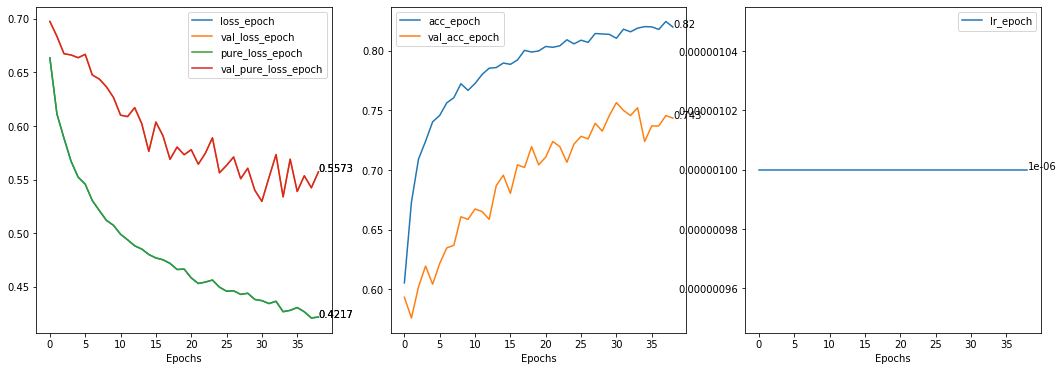

Epoch 40/100


In [0]:
#Launch primary model training

batch_size = 32 #Decrease in case of memory issues

val_batch_size = hand_valid_labels.shape[0]
validation_steps= hand_valid_labels.shape[0] // val_batch_size #Validate on full set

epochs = 100 + epoch_counter.epoch #For multiple launches

hand_model_history = hand_model.fit_generator(
    datagen.flow(hand_train, hand_train_labels, batch_size=batch_size, shuffle=True),
    validation_data=datagen.flow(hand_valid, hand_valid_labels, batch_size=val_batch_size, shuffle=False),
    validation_steps=validation_steps,
    class_weight=class_weight,
    epochs=epochs,
    callbacks=callbacks,
    initial_epoch=epoch_counter.epoch,
    steps_per_epoch=np.ceil(hand_train_labels.shape[0] / batch_size),
    verbose=2
)

histories[epoch_counter.epoch]=hand_model_history